In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression, Lasso, Ridge
import statsmodels.api as sm
import statsmodels.formula.api as smf 


## clean games data

In [27]:
#read in game data for all teams
df=pd.read_csv('/Users/andreewerner/Desktop/mlb-game-data.csv')


In [28]:
df.drop_duplicates(inplace=True)

In [29]:
# check attendance since it many not be the same across the tow games in double header
print(df[(df['attendance'].isnull()) & (df['double_header']==1)].shape)
print(df[(df['attendance'].isnull()) & (df['double_header']==0)].shape)
print(df[(df['attendance'].notnull()) & (df['double_header']==1)].shape)


(197, 25)
(2, 25)
(701, 25)


In [30]:
# only keep rows where attendance is non-null
df=df[df['attendance'].notnull()]
df.shape

(43529, 25)

In [31]:
# get rid of commas in attendance numbers and change to int object 
df['attendance'] = df['attendance'].str.replace(',','').astype(int)



In [32]:
#change other columns to int objects 
for val in ['runs','runs_allowed','rank']:
    df[val]=df[val].astype(int)

In [33]:
# find win percentage
wins=[]
losses=[]
for wl in df['WL_record']:
    w,l = wl.split('-')
    wins.append(int(w))
    losses.append(int(l))
    
df['wins']=wins
df['losses']=losses
df['wins_and_losses']=df['wins'] + df['losses']
df['win_percentage']=df['wins']/(df['wins'] + df['losses'])

#fill null values with 0 to represent first game of season
df['win_percentage'].fillna(0,inplace=True)

In [34]:
# change non-floats to floats in gb column and fill in str values with floats 
df['gb']=[0.0 if x == ' Tied' or x == '0'
         else float(x.replace('up','')) if 'up' in x
         else -float(x)
         for x in df.gb]

In [35]:
# change streak column to int object 
df['streak'].fillna('0',inplace=True)
df['streak']=[len(x) if '+' in x
             else -(len(x)) if '-' in x
             else 0 for x in df['streak']]

In [36]:
# convert d_or_n to dummy
df['day_game'] = [1 if x == 'D' else 0 for x in df['d_or_n']]

In [37]:
#change date to datetime and add some useful columns(day,weekday,month, year)
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday_name'] = df['date'].dt.weekday_name
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year


In [38]:
# change time to timedelta to find difference 
df['time']= pd.to_timedelta([x + ':00' for x in df['time']])

In [39]:
#fill NaN's for runs_moving_avg and win_pct for last 10 games
df['runs_moving_avg'] = [df.iloc[i]['runs_per_game'] if np.isnan(j) else j for i,j in enumerate(df['runs_moving_avg'])]
df['win_pct'] = [df.iloc[i]['win_percentage'] if np.isnan(j) else j for i,j in enumerate(df['win_pct'])]


In [40]:
# clean up dataframe and drop no longer useful columns
df.drop(['box','at','w_or_l','runs','runs_allowed','innings','WL_record','winning_pitcher','losing_pitcher',
        'save','d_or_n','wins','losses'],axis=1,inplace=True)

In [41]:
df.info()
df.dtypes
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 43529 entries, 0 to 43727
Data columns (total 22 columns):
date                       43529 non-null datetime64[ns]
team                       43529 non-null object
opponent                   43529 non-null object
rank                       43529 non-null int64
gb                         43529 non-null float64
time                       43529 non-null timedelta64[ns]
attendance                 43529 non-null int64
streak                     43529 non-null int64
double_header              43529 non-null int64
runs_per_game              43529 non-null float64
runs_moving_avg            43529 non-null float64
runs_allowed_moving_avg    43529 non-null float64
win_pct                    43529 non-null float64
opening_day                43529 non-null int64
wins_and_losses            43529 non-null int64
win_percentage             43529 non-null float64
day_game                   43529 non-null int64
day                        43529 non-null 

date                       0
team                       0
opponent                   0
rank                       0
gb                         0
time                       0
attendance                 0
streak                     0
double_header              0
runs_per_game              0
runs_moving_avg            0
runs_allowed_moving_avg    0
win_pct                    0
opening_day                0
wins_and_losses            0
win_percentage             0
day_game                   0
day                        0
weekday                    0
weekday_name               0
month                      0
year                       0
dtype: int64

## get stadiums data to add to game data 


In [42]:
stadiums = pd.read_csv('/Users/andreewerner/Downloads/MLB - stadiums.csv')

In [43]:
stadiums.Year.sort_values().unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [44]:
stadiums.Team.sort_values().unique()

array(['ANA', 'ARI', 'ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN',
       'CLE', 'COL', 'DET', 'FLA', 'HOU', 'KCR', 'LAA', 'LAD', 'MIA',
       'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP',
       'SEA', 'SFG', 'STL', 'TBD', 'TBR', 'TEX', 'TOR', 'WSN'],
      dtype=object)

In [45]:
stadiums[stadiums.Team == 'ANA']
stadiums[stadiums.Team == 'ARI']
stadiums[stadiums.Team == 'ATL']
stadiums[stadiums.Team == 'BAL']
stadiums[stadiums.Team == 'BOS']
stadiums[stadiums.Team == 'CAL']
stadiums[stadiums.Team == 'CHC']
stadiums[stadiums.Team == 'CHW']
stadiums[stadiums.Team == 'CIN']
stadiums[stadiums.Team == 'CLE']
stadiums[stadiums.Team == 'COL']
stadiums[stadiums.Team == 'DET']
stadiums[stadiums.Team == 'FLA']
stadiums[stadiums.Team == 'HOU']
stadiums[stadiums.Team == 'KCR']
stadiums[stadiums.Team == 'LAA']
stadiums[stadiums.Team == 'LAD']
stadiums[stadiums.Team == 'MIA']
stadiums[stadiums.Team == 'MIL']
stadiums[stadiums.Team == 'MIN']
stadiums[stadiums.Team == 'MON']
stadiums[stadiums.Team == 'NYM']
stadiums[stadiums.Team == 'NYY']
stadiums[stadiums.Team == 'OAK']
stadiums[stadiums.Team == 'PHI']
stadiums[stadiums.Team == 'PIT']
stadiums[stadiums.Team == 'SDP']
stadiums[stadiums.Team == 'SEA']
stadiums[stadiums.Team == 'SFG']
stadiums[stadiums.Team == 'STL']
stadiums[stadiums.Team == 'TBD']
stadiums[stadiums.Team == 'TBR']
stadiums[stadiums.Team == 'TEX']
stadiums[stadiums.Team == 'TOR']
stadiums[stadiums.Team == 'WSN'];

In [46]:
stadiums.dtypes
stadiums.head()

,Team,Year,State,Stadium,Capacity
0,ANA,1997,California,Angel Stadium,33851
1,ANA,1998,California,Angel Stadium,45050
2,ANA,1999,California,Angel Stadium,45050
3,ANA,2000,California,Angel Stadium,45050
4,ANA,2001,California,Angel Stadium,45050


In [47]:
# merge with df dataframe

#first make column headings of stadiums dataframe lowercase

stadiums.columns = [x.lower() for x in stadiums.columns]

#drop state column
stadiums = stadiums.drop(['state'],axis = 1)

#perform merge
df=df.merge(stadiums,on=['team','year'])

In [48]:
df.isnull().sum()
df.head()

,date,team,opponent,rank,gb,time,attendance,streak,double_header,runs_per_game,...,wins_and_losses,win_percentage,day_game,day,weekday,weekday_name,month,year,stadium,capacity
0,2000-04-03,ANA,NYY,0,0.0,03:02:00,42704,0,0,0.000000,...,0,0.000000,0,3,0,Monday,4,2000,Angel Stadium,45050
1,2000-04-04,ANA,NYY,3,-1.0,03:20:00,25818,-1,0,2.000000,...,1,0.000000,0,4,1,Tuesday,4,2000,Angel Stadium,45050
2,2000-04-05,ANA,NYY,4,-2.0,03:01:00,24560,-2,0,2.500000,...,2,0.000000,0,5,2,Wednesday,4,2000,Angel Stadium,45050
3,2000-04-07,ANA,BOS,4,-1.0,02:28:00,30412,1,0,5.666667,...,3,0.333333,0,7,4,Friday,4,2000,Angel Stadium,45050
4,2000-04-08,ANA,BOS,3,-1.0,03:11:00,27369,2,0,6.000000,...,4,0.500000,0,8,5,Saturday,4,2000,Angel Stadium,45050


## clean seasons data 

In [49]:
seasons_df = pd.read_csv('/Users/andreewerner/Desktop/mlb-seasons-data.csv')

In [50]:
seasons_df.isnull().sum()
seasons_df.head()

,year,team,team_name,division,G,W,L,ties,win_pct,p_win_pct,...,playoffs,R,RA,attendance,bat_age,pitch_age,num_bat,num_pitch,top_player,managers
0,2017,ANA,NaN,AL West,162,80,82,0,0.494,0.501,...,NaN,710,709,"3,019,585",29.9,29.1,55,31,A.Simmons (7.1),NaN
1,2016,ANA,NaN,AL West,162,74,88,0,0.457,0.494,...,NaN,717,727,"3,016,142",28.5,28.4,53,30,M.Trout (10.5),NaN
2,2015,ANA,NaN,AL West,162,85,77,0,0.525,0.490,...,NaN,661,675,"3,012,765",28.7,28.3,51,25,M.Trout (9.4),NaN
3,2014,ANA,NaN,AL West,162,98,64,0,0.605,0.593,...,NaN,773,630,"3,095,935",29.3,28.4,54,31,M.Trout (7.6),NaN
4,2013,ANA,NaN,AL West,162,78,84,0,0.481,0.498,...,NaN,733,737,"3,019,505",27.8,29.1,49,26,M.Trout (9.0),NaN


In [51]:
# put zeros in for '--' in gb column and change other values to float objects
seasons_df['gb'] = [0. if i =='--' else float(i) for i in seasons_df['gb']]

In [52]:
#make playoffs a dummy variable, 0 for NaNs, 2 if they won playoffs, 1 otherwise
seasons_df['playoffs'] = [0 if str(i) == 'NaN' else 2 if 'Won' in str(i) else 1 for i in seasons_df['playoffs']]


In [53]:
#split top_player column into 2 columsn: player name and their one encompassing stat
top_player=[]
top_player_stat=[]
for player in seasons_df['top_player']:
    p,s = player.split()
    top_player.append(p)
    top_player_stat.append(float(s.replace('(','').replace(')','')))

seasons_df['top_player'] = top_player
seasons_df['top_player_stat'] = top_player_stat

In [54]:
#attendance to int object
seasons_df['attendance'] = seasons_df['attendance'].str.replace(',','').astype(int)

In [55]:
# drop unnecessary columns
seasons_df=seasons_df.drop(['W','L','ties','team_name','p_win_pct','finish','R','RA','num_bat','num_pitch','managers'],axis=1)


In [56]:
# define count of games based on unique team and year in order to find average attendance per game
games_count = pd.DataFrame(columns=['team','year','home_games_count'])
for i in df['team'].unique():
    for j in df[df['team'] ==i]['year'].unique():
        games_count.loc[len(games_count)] = [i,j, float(len(df[(df['year'] == j) & (df['team'] == i)]))]

games_count['home_games_count'] = games_count['home_games_count'].astype(int)
games_count['year']=games_count['year'].astype(int)

# put into seasons dataframe
seasons_df=seasons_df.merge(games_count,on=['team','year'])
seasons_df['avg_attend_per_game'] = seasons_df['attendance']/seasons_df['home_games_count']

In [57]:
# merge seasons and dataframe and stadiums dataframe, on year and team
seasons_df=seasons_df.merge(stadiums, on =['team','year'])
seasons_df.columns

Index(['year', 'team', 'division', 'G', 'win_pct', 'gb', 'playoffs',
       'attendance', 'bat_age', 'pitch_age', 'top_player', 'top_player_stat',
       'home_games_count', 'avg_attend_per_game', 'stadium', 'capacity'],
      dtype='object')

## INFO FROM GAMES DF DATAFRAME 

## histogram of target variable (attendance) looks pretty normal 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.0, 5e-05)

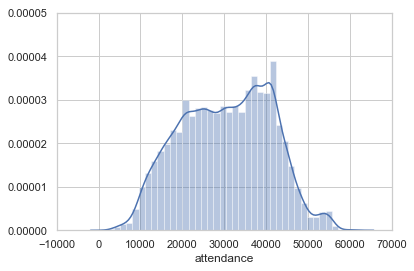

In [58]:
sns.set_style('whitegrid')
sns.distplot(df['attendance'],bins=40)
plt.xlim(-10000,70000)
plt.ylim(0.000000,0.000050)

## correlation heat map 

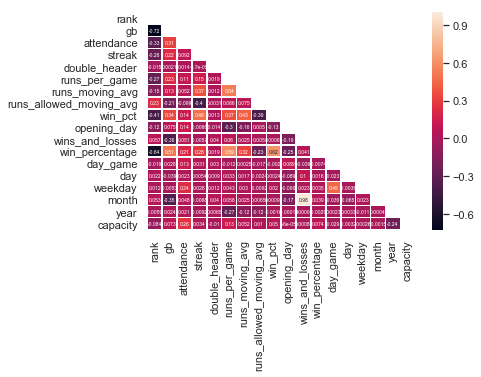

In [59]:
df_corr=df.corr()

mask = np.zeros_like(df_corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr, linewidth = 0.5, mask=mask, annot=True, annot_kws={'size': 5})

## regression plot for win_percentage against attendance - slight positive 


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


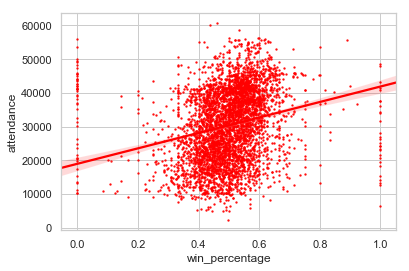

In [60]:
sns.regplot(x='win_percentage',y='attendance',data=df.sample(frac=0.1),marker='o',color='red',scatter_kws={'s':2})

## regression plot for gb against attendance - positive correlation 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


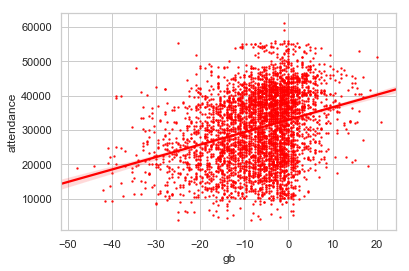

In [61]:
sns.regplot(x='gb',y='attendance',data=df.sample(frac=0.1),marker='o',color='red',scatter_kws={'s':2})

## regression plot for runs_per_game against attendance - hard to tell

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


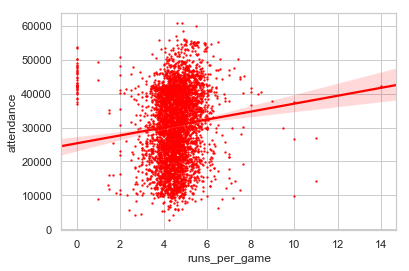

In [62]:
sns.regplot(x='runs_per_game',y='attendance',data=df.sample(frac=0.1),marker='o',color='red',scatter_kws={'s':2})

## regression plot for rank against attendance - negative correlation

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


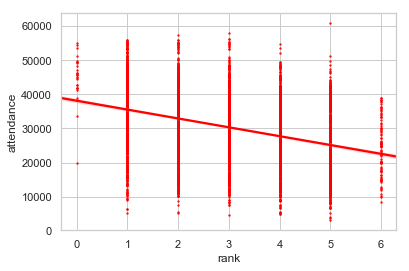

In [63]:
sns.regplot(x='rank',y='attendance',data=df.sample(frac=0.1),marker='o',color='red',scatter_kws={'s':2})

## boxplot for day of week against attendance 

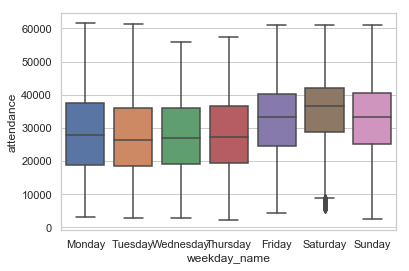

In [64]:
sns.boxplot(x='weekday_name', y='attendance', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

## boxplot of season months (march-oct) against attendance 

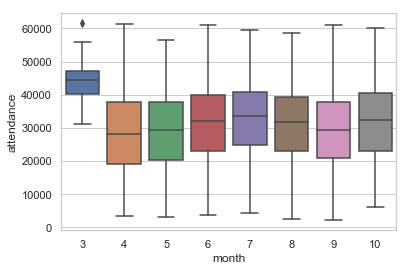

In [65]:
#that outlier is the max attendance game by SDP in march 2003  
sns.boxplot(x='month', y='attendance', data=df)


## boxplot of opening-day game and that affect on attendance

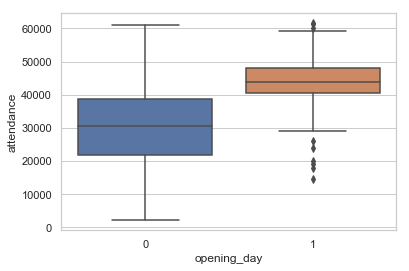

In [66]:
sns.boxplot(x='opening_day', y='attendance', data=df)


In [67]:
df.describe()

,rank,gb,time,attendance,streak,double_header,runs_per_game,runs_moving_avg,runs_allowed_moving_avg,win_pct,opening_day,wins_and_losses,win_percentage,day_game,day,weekday,month,year,capacity
count,43529.000000,43529.000000,43529,43529.000000,43529.000000,43529.000000,43529.000000,43529.000000,43529.000000,43529.000000,43529.000000,43529.000000,43529.000000,43529.000000,43529.000000,43529.000000,43529.000000,43529.000000,43529.000000
mean,2.937329,-6.532002,0 days 02:57:56.017827,30444.824623,0.131751,0.016104,4.539647,4.546501,4.552501,0.457113,0.012406,80.413954,0.497315,0.323807,15.852122,3.203565,6.567530,2008.506835,44641.665579
std,1.470698,8.815325,0 days 00:27:29.056318,10778.203708,2.561186,0.125878,0.828199,1.558592,1.500691,0.179979,0.110688,46.722685,0.112005,0.467933,8.864488,1.969903,1.722032,5.187334,5867.755214
min,0.000000,-49.000000,0 days 01:15:00,2134.000000,-15.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,2000.000000,31042.000000
25%,2.000000,-11.500000,0 days 02:40:00,21840.000000,-1.000000,0.000000,4.118182,3.400000,3.400000,0.300000,0.000000,40.000000,0.440000,0.000000,8.000000,1.000000,5.000000,2004.000000,41070.000000
50%,3.000000,-5.000000,0 days 02:55:00,30874.000000,1.000000,0.000000,4.533333,4.400000,4.400000,0.500000,0.000000,80.000000,0.500000,0.000000,16.000000,3.000000,7.000000,2009.000000,43500.000000
75%,4.000000,-1.000000,0 days 03:12:00,39082.000000,2.000000,0.000000,4.957143,5.600000,5.400000,0.600000,0.000000,121.000000,0.558824,1.000000,24.000000,5.000000,8.000000,2013.000000,48876.000000
max,6.000000,22.000000,0 days 07:06:00,61707.000000,22.000000,1.000000,16.000000,16.000000,12.800000,1.000000,1.000000,162.000000,1.000000,1.000000,31.000000,6.000000,10.000000,2017.000000,66307.000000


In [68]:
#find game with minimum attendance 
df[df['attendance'] == min(df['attendance'])]
# montreal, no longer exists in 2002

,date,team,opponent,rank,gb,time,attendance,streak,double_header,runs_per_game,...,wins_and_losses,win_percentage,day_game,day,weekday,weekday_name,month,year,stadium,capacity
24907,2002-09-05,MON,PHI,3,-19.5,02:17:00,2134,3,0,4.510791,...,139,0.496403,1,5,3,Thursday,9,2002,Olympic Stadium,45757


In [69]:
#find game with max attendance
df[df['attendance'] == max(df['attendance'])]


,date,team,opponent,rank,gb,time,attendance,streak,double_header,runs_per_game,...,wins_and_losses,win_percentage,day_game,day,weekday,weekday_name,month,year,stadium,capacity
33578,2003-03-31,SDP,SFG,0,0.0,02:54:00,61707,0,0,0.0,...,0,0.0,1,31,0,Monday,3,2003,Qualcomm Stadium,63890


## INFO FROM SEASONS DF

In [70]:
seasons_df.sort_values('attendance').head(10)



,year,team,division,G,win_pct,gb,playoffs,attendance,bat_age,pitch_age,top_player,top_player_stat,home_games_count,avg_attend_per_game,stadium,capacity
194,2002,FLA,NL East,162,0.488,23.0,1,813118,28.4,26.1,A.Burnett,4.0,81,10038.493827,Sun Life Stadium,42531
305,2000,MIN,AL Central,162,0.426,26.0,1,1000760,26.5,26.6,B.Radke,6.2,81,12355.061728,Metrodome,48678
472,2003,TBD,AL East,162,0.389,38.0,1,1058695,26.3,26.4,A.Huff,4.0,81,13070.308642,Tropicana,43772
473,2002,TBD,AL East,161,0.342,48.0,1,1065742,27.1,26.9,R.Winn,4.9,81,13157.308642,Tropicana,43772
470,2005,TBD,AL East,162,0.414,28.0,1,1141669,27.5,27.4,J.Lugo,4.4,81,14094.679012,Tropicana,43772
190,2006,FLA,NL East,162,0.481,19.0,1,1164134,25.5,25.9,M.Cabrera,5.8,81,14372.024691,Sun Life Stadium,36331
196,2000,FLA,NL East,161,0.491,15.5,1,1218326,26.1,26.7,L.Castillo,4.5,80,15229.075000,Sun Life Stadium,47662
476,2017,TBR,AL East,162,0.494,13.0,1,1253619,28.3,27.6,K.Kiermaier,5.1,80,15670.237500,Tropicana,31042
195,2001,FLA,NL East,162,0.469,12.0,1,1261226,27.3,26.5,C.Floyd,6.6,80,15765.325000,Sun Life Stadium,42531
471,2004,TBD,AL East,161,0.435,30.5,1,1274911,28.1,27.5,C.Crawford,4.9,79,16138.113924,Tropicana,43772


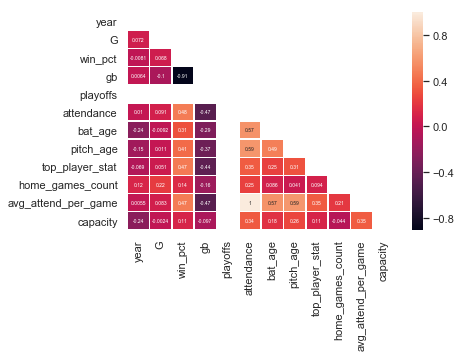

In [71]:
seasons_df_corr=seasons_df.corr()

mask = np.zeros_like(seasons_df_corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(seasons_df_corr, linewidth = 0.5, mask=mask, annot=True, annot_kws={'size': 5})

## bat_age against attendance

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


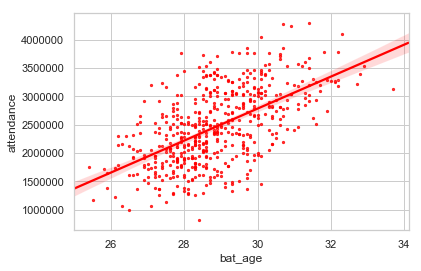

In [72]:
sns.regplot(x='bat_age', y='attendance', data=seasons_df,marker='o',color='red',scatter_kws={'s':5})


In [73]:
seasons_df[(seasons_df['bat_age']<26) | (seasons_df['bat_age']>32)].sort_values('bat_age')

,year,team,division,G,win_pct,gb,playoffs,attendance,bat_age,pitch_age,top_player,top_player_stat,home_games_count,avg_attend_per_game,stadium,capacity
200,2014,HOU,AL West,162,0.432,28.0,1,1751829,25.4,27.9,J.Altuve,6.1,81,21627.518519,Minute Maid Park,42060
190,2006,FLA,NL East,162,0.481,19.0,1,1164134,25.5,25.9,M.Cabrera,5.8,81,14372.024691,Sun Life Stadium,36331
221,2011,KCR,AL Central,162,0.438,24.0,1,1724450,25.8,26.4,A.Gordon,7.3,81,21289.506173,Kauffman Stadium,40625
201,2013,HOU,AL West,162,0.315,45.0,1,1651883,25.9,27.2,J.Castro,4.1,81,20393.617284,Minute Maid Park,42060
468,2007,TBD,AL East,162,0.407,30.0,1,1387603,25.9,27.0,C.Pena,7.2,81,17130.901235,Tropicana,38437
428,2003,SFG,NL West,161,0.621,0.0,1,3264898,32.1,28.6,B.Bonds,9.2,81,40307.382716,AT&T Park,41503
429,2002,SFG,NL West,162,0.590,2.5,1,3253203,32.1,29.2,B.Bonds,11.8,81,40163.000000,AT&T Park,41059
58,2000,BAL,AL East,162,0.457,13.5,1,3297031,32.2,29.1,M.Mussina,5.6,81,40704.086420,Oriole Park,48876
337,2004,NYY,AL East,162,0.623,0.0,1,3775292,32.2,32.9,A.Rodriguez,7.6,79,47788.506329,Yankee Stadium I,57478
426,2005,SFG,NL West,162,0.463,7.0,1,3181023,32.2,30.0,N.Lowry,4.8,81,39271.888889,AT&T Park,41584


## pitch_age against attendance

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


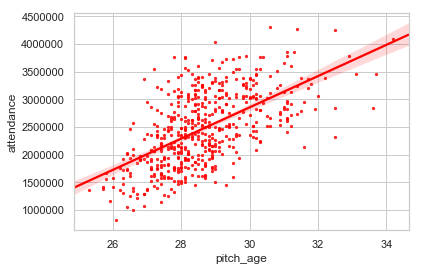

In [74]:
sns.regplot(x='pitch_age', y='attendance', data=seasons_df,marker='o',color='red',scatter_kws={'s':5})


## top player stats against attendance

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


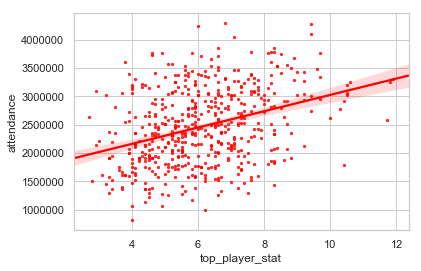

In [75]:
sns.regplot(x='top_player_stat', y='attendance', data=seasons_df,marker='o',color='red',scatter_kws={'s':5})


In [76]:
seasons_df[seasons_df['top_player_stat']>10].sort_values('top_player_stat')

,year,team,division,G,win_pct,gb,playoffs,attendance,bat_age,pitch_age,top_player,top_player_stat,home_games_count,avg_attend_per_game,stadium,capacity
93,2001,CHC,NL Central,162,0.543,5.0,1,2779465,30.7,29.8,S.Sosa,10.3,79,35183.101266,Wrigley Field,41072
223,2009,KCR,AL Central,162,0.401,21.5,1,1797891,27.6,28.7,Z.Greinke,10.4,80,22473.637500,Kauffman Stadium,40625
449,2000,SEA,AL West,162,0.562,0.5,1,2914624,31.4,29.3,A.Rodriguez,10.4,81,35983.012346,Safeco Field,47116
20,2002,ARI,NL West,162,0.605,0.0,1,3198977,31.7,31.7,R.Johnson,10.5,81,39493.543210,Chase Field,49033
234,2016,LAA,AL West,162,0.457,21.0,1,3016142,28.5,28.4,M.Trout,10.5,81,37236.320988,Angel Stadium,45483
238,2012,LAA,AL West,162,0.549,5.0,1,3061770,28.7,30.1,M.Trout,10.5,81,37799.629630,Angel Stadium,45957
427,2004,SFG,NL West,162,0.562,2.0,1,3256854,31.6,30.1,B.Bonds,10.6,81,40208.074074,AT&T Park,41503
76,2000,BOS,AL East,162,0.525,2.5,1,2585895,29.3,30.2,P.Martinez,11.7,81,31924.629630,Fenway Park,33871
429,2002,SFG,NL West,162,0.590,2.5,1,3253203,32.1,29.2,B.Bonds,11.8,81,40163.000000,AT&T Park,41059
430,2001,SFG,NL West,162,0.556,2.0,1,3311958,31.5,29.2,B.Bonds,11.9,81,40888.370370,AT&T Park,41059


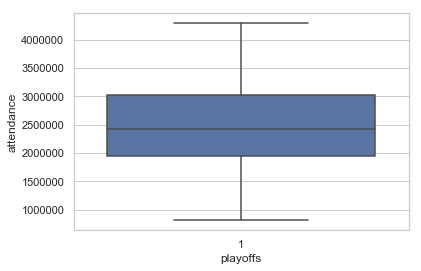

In [77]:
sns.boxplot(x='playoffs', y='attendance', data=seasons_df)
# but maybe 1 is higher simply since that's a bigger sample size, not as many teams make it to playoffs

## add some important features to df, like bat/pitch_age, top_player_stat, 

In [78]:
df = df.merge(seasons_df[['team', 'year', 'bat_age', 'pitch_age', 'division','top_player_stat']],
                            on=['team', 'year'])

#change team_x of seasons_df to opponent in df, team_x is now original team in df. division_x is division of team of interest, division_y os division of opponent. 
df = df.merge(seasons_df[['team', 'year', 'division']], left_on=['opponent', 'year'], right_on=['team', 'year'])


In [79]:
#create new columm that tells if it's a division game or not. That is, if the two teams playing are from the same division or not  
df['division_game'] = [1 if df.loc[i]['division_x'] == df.loc[i]['division_y'] else 0 for i in range(0,len(df))]


# drop columns 
df.drop(['division_x', 'team_y', 'division_y'], axis=1, inplace=True)


In [80]:
df.dtypes

date                        datetime64[ns]
team_x                              object
opponent                            object
rank                                 int64
gb                                 float64
time                       timedelta64[ns]
attendance                           int64
streak                               int64
double_header                        int64
runs_per_game                      float64
runs_moving_avg                    float64
runs_allowed_moving_avg            float64
win_pct                            float64
opening_day                          int64
wins_and_losses                      int64
win_percentage                     float64
day_game                             int64
day                                  int64
weekday                              int64
weekday_name                        object
month                                int64
year                                 int64
stadium                             object
capacity   

In [81]:
df['day_game'].value_counts()

0    28859
1    13869
Name: day_game, dtype: int64

## box plot for day vs. night game and attendance effect

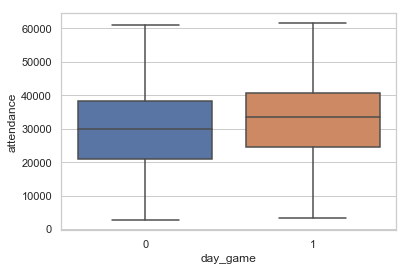

In [82]:
sns.boxplot(x='day_game', y='attendance', data=df)
# not much different, slightly higher mean if it's a day game  

In [83]:
df['division_game'].value_counts()

0    23540
1    19188
Name: division_game, dtype: int64

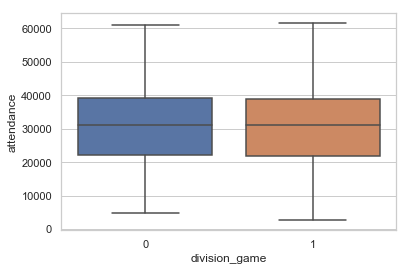

In [84]:
sns.boxplot(x='division_game', y='attendance', data=df)


## to_csv

In [87]:
df.to_csv('/Users/andreewerner/Desktop/mlb-master_df-data.csv', index=False, encoding = 'utf-8')


In [90]:
for i in df['team_x'].unique():
    game_df = df[df['team_x'] == i]
    game_df.to_csv('/Users/andreewerner/Desktop/' + i + '-game-data.csv', index=False, encoding='utf-8')


In [91]:
seasons_df.to_csv('/Users/andreewerner/Desktop/mlb-master_seasons_df-data.csv', index=False, encoding = 'utf-8')
